# My first Data Science job interview

### So this notebook works with some fiction samples to show off the techniques demanded on my first Data Science job interview, which consisted basically working with pandas

## Import Samples
All samples were created randomly

In [29]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
stores = pd.read_excel('samples.xlsx',sheet_name='stores')
customer = pd.read_excel('samples.xlsx', sheet_name='customer')
product = pd.read_excel('samples.xlsx', sheet_name='products')
transactions = pd.read_excel('samples.xlsx', sheet_name='transactions')

In [3]:
# Lets check the shapes of each df
stores.shape, customer.shape, product.shape, transactions.shape

((10, 3), (55, 3), (20, 4), (205, 8))

In [4]:
# now let's print the first 5 lines to see the columns
stores.head()

,store_id,store_name,state
0,1,Store A,SP
1,2,Store B,RJ
2,3,Store C,MG
3,4,Store D,MT
4,5,Store E,RS


In [5]:
customer.head()

,customer_id,age,gender
0,1,20,F
1,2,18,M
2,3,34,M
3,4,38,F
4,5,28,M


In [6]:
product.head()

,product_id,product_name,supplier,department
0,1,Product A,Supplier A,Department A
1,2,Product B,Supplier A,Department A
2,3,Product C,Supplier A,Department A
3,4,Product D,Supplier B,Department A
4,5,Product E,Supplier B,Department A


In [7]:
transactions.head()

,customer_id,store_id,date_id,ticket_id,product_id,unit_price,quantity,sales
0,31,1,2020-04-28,1,13,2,14,28
1,22,10,2020-03-09,2,17,25,31,775
2,38,3,2020-05-22,3,4,7,25,175
3,27,9,2020-04-04,4,18,4,31,124
4,3,4,2020-02-07,5,2,16,30,480


### Question 1
Sort (ascending) table "customer" by customer_id and remove duplicates:

In [8]:
# first sort values (ascending=True is default, but it's here to demonstrate)
# then drop duplicates with ignore_index=True to label indeces as 0,1,...,n-1
customer = customer.sort_values(by='customer_id', ascending=True).drop_duplicates(ignore_index=True)
print(customer.shape)
customer.head()

(50, 3)


,customer_id,age,gender
0,1,20,F
1,2,18,M
2,3,34,M
3,4,38,F
4,5,28,M


### Question 2
Create table "transaction_cube" merging all tables:

In [9]:
# pandas merge has by default inner join, which we can apply to merge the fact table transactions
# merging over the fact SKs and all other PKs of the dimension tables
transactions_stores = transactions.merge(stores, on='store_id') # SK store_id
transactions_customer = transactions_stores.merge(customer, on='customer_id') # SK customer_id
transaction_cube = transactions_customer.merge(product, on='product_id') # SK product_id
print(transaction_cube.shape)
transaction_cube.head()

(153, 15)


,customer_id,store_id,date_id,ticket_id,product_id,unit_price,quantity,sales,store_name,state,age,gender,product_name,supplier,department
0,31,1,2020-04-28,1,13,2,14,28,Store A,SP,24,M,Product M,Supplier E,Department B
1,33,6,2020-03-19,96,13,21,11,231,Store F,RN,32,M,Product M,Supplier E,Department B
2,37,2,2020-05-18,27,13,17,35,595,Store B,RJ,40,M,Product M,Supplier E,Department B
3,42,10,2020-05-24,42,13,30,43,1290,Store J,RN,24,M,Product M,Supplier E,Department B
4,10,3,2020-04-27,50,13,6,7,42,Store C,MG,23,F,Product M,Supplier E,Department B


### Question 3
Create table "customer_ids" with customers that exists in the "transactions" table but not in the "customer" table:

In [10]:
# we apply an outer join with an indicator where customer_id is present on left table ("transaction") only 
customer_ids = transactions.merge(customer, indicator='i', how='outer').query('i == "left_only"').drop('i',axis=1)
customer_ids

,customer_id,store_id,date_id,ticket_id,product_id,unit_price,quantity,sales,age,gender
200,51,13.0,2020-05-03,4.0,16.0,22.0,40.0,880.0,NaN,NaN
201,52,3.0,2020-07-31,8.0,13.0,7.0,50.0,350.0,NaN,NaN
202,53,16.0,2020-05-09,1.0,7.0,9.0,33.0,297.0,NaN,NaN
203,54,8.0,2020-07-29,10.0,8.0,10.0,36.0,360.0,NaN,NaN
204,55,10.0,2020-04-02,15.0,10.0,29.0,30.0,870.0,NaN,NaN


### Question 4
Create table "customer_summary" with the following variables:
- customer_id
- department -> count of departments
- total_sales -> sum of sales
- total_quantity -> sum of quantity
- average_ticket -> mean of sales
- last_visit

In [11]:
# we must groupby the variables by customer_id, making the necessary operations for each case
transaction_cube['date_id'] = pd.to_datetime(transaction_cube['date_id']) # date_id as datetime
customer_id = sorted(transaction_cube['customer_id'].unique())
customer_summary = pd.DataFrame(customer_id, columns=['customer_id'])
customer_summary['department'] = transaction_cube.groupby(['customer_id'])['department'].count().to_list()
customer_summary['total_sales'] = transaction_cube.groupby(['customer_id'])['sales'].sum().to_list()
customer_summary['total_quantity'] = transaction_cube.groupby(['customer_id'])['quantity'].sum().to_list()
customer_summary['average_ticket'] = transaction_cube.groupby(['customer_id'])['sales'].mean().to_list()
customer_summary['last_visit'] = transaction_cube.groupby(['customer_id'])['date_id'].max().to_list()
customer_summary.set_index('customer_id', inplace=True)
customer_summary.head()

,department,total_sales,total_quantity,average_ticket,last_visit
customer_id,,,,,
1,1,484,22,484.000000,2020-04-07
2,2,726,46,363.000000,2020-03-12
3,3,1508,81,502.666667,2020-06-17
4,3,1380,66,460.000000,2020-05-26
5,3,1812,82,604.000000,2020-04-16


### Question 5
Create table "customer_metrics" with the following variables:
- customer_id
- department
- total_sales
- total_quantity
- product_name -> product that sold the most per consumer
- price_median -> median of price

In [12]:
customer_metrics = customer_summary.copy()
gb = transaction_cube.groupby(['customer_id','product_name']).count(); gb.reset_index(inplace=True)
gb = gb.sort_values('store_id', ascending=False).groupby(['customer_id']).first()
customer_metrics['product_name'] = gb['product_name']
customer_metrics['price_median'] = transaction_cube.groupby(['customer_id'])['unit_price'].median()
customer_metrics.head()

,department,total_sales,total_quantity,average_ticket,last_visit,product_name,price_median
customer_id,,,,,,,
1,1,484,22,484.000000,2020-04-07,Product C,22.0
2,2,726,46,363.000000,2020-03-12,Product N,21.0
3,3,1508,81,502.666667,2020-06-17,Product H,16.0
4,3,1380,66,460.000000,2020-05-26,Product L,16.0
5,3,1812,82,604.000000,2020-04-16,Product R,20.0


## Clustering
Now, just to step inside <i>machine learning</i> a little, let's apply a cluster model in this small sample. We'll apply <b>KMeans</b> clustering algorithm to cluster the customers:

In [13]:
df = customer_metrics[['average_ticket']]
df['first_visit'] = transaction_cube.groupby(['customer_id'])['date_id'].min().to_list()
df['recency'] = transaction_cube['date_id'].max() - df['first_visit']
df['recency'] = df['recency'].dt.days
df.drop('first_visit', axis=1, inplace=True)
df.columns = ['monetary','recency']
df['frequency'] = transaction_cube.customer_id.value_counts().sort_index().to_list()
#df.reset_index(inplace=True); df.drop('customer_id', axis=1, inplace=True)
df.head()

,monetary,recency,frequency
customer_id,,,
1,484.000000,115,1
2,363.000000,153,2
3,502.666667,175,3
4,460.000000,165,3
5,604.000000,175,3


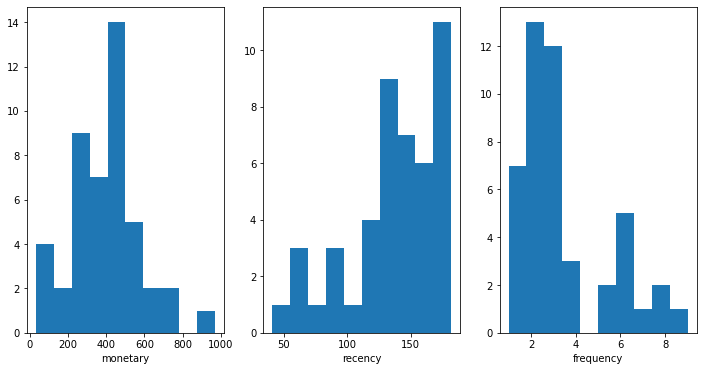

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,6))
ax1.hist(df.monetary); ax1.set_xlabel('monetary');
ax2.hist(df.recency); ax2.set_xlabel('recency');
ax3.hist(df.frequency); ax3.set_xlabel('frequency');

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [15]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
print(df_scaled.shape)
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = ['monetary','recency','frequency']
df_scaled.head()

(46, 3)


,monetary,recency,frequency
0,0.471626,-0.602176,-1.132354
1,-0.199901,0.438975,-0.645548
2,0.575223,1.041747,-0.158741
3,0.338431,0.767760,-0.158741
4,1.137603,1.041747,-0.158741


In [16]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan

# hopkins statistic indicates the cluster tendency (how well data can be clustered)
# values above 0.7 have a high tendency of cluster
def hopkins(X):
    d = X.shape[1]
    n = len(X) 
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, 
                                    return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [17]:
hopkins(df_scaled)

0.7197729529893124

In [18]:
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [19]:
df['cluster'] = kmeans.labels_
df.head()

,monetary,recency,frequency,cluster
customer_id,,,,
1,484.000000,115,1,2
2,363.000000,153,2,0
3,502.666667,175,3,0
4,460.000000,165,3,0
5,604.000000,175,3,0


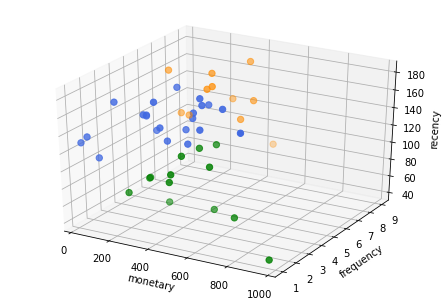

In [28]:
df['color'] = df['cluster'].map({0:'royalblue', 1:'darkorange', 2:'green'})
fig = plt.figure(); ax = Axes3D(fig)
ax.scatter(df.monetary, df.frequency, df.recency, c=df.color, s=40)
ax.set_xlabel('monetary')
ax.set_ylabel('frequency')
ax.set_zlabel('recency');

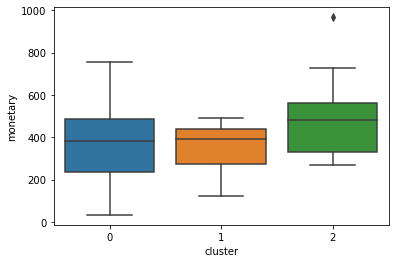

In [27]:
import seaborn as sns

sns.boxplot(df.cluster, df.monetary);

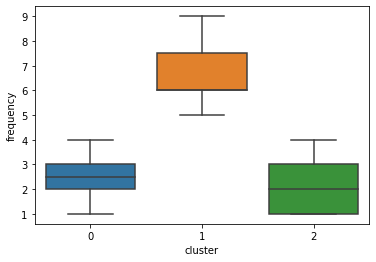

In [22]:
sns.boxplot(df.cluster, df.frequency);

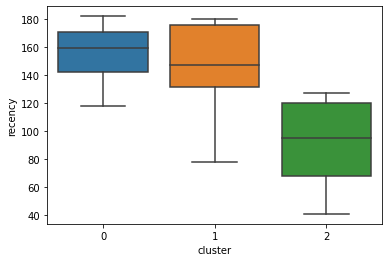

In [23]:
sns.boxplot(df.cluster, df.recency);

In [24]:
df.cluster.value_counts()

0    22
2    13
1    11
Name: cluster, dtype: int64

#### Boxplot Analysis:
- From the <b>monetary</b> boxplot: Cluster 0 > Cluster 2 > Cluster 1;
- From the <b>frequency</b> boxplot: Cluster 0 > Cluster 2 > Cluster 1;
- From the <b>recency</b> boxplot: Cluster 0 > Cluster 1 > Cluster 2;

#### Highlights:
- <b>Cluster 0:</b> customers that have a large range of average ticket (close to 0 up to 800), not so frequent but old buyers, and compose the majority of customers (22 of 46 = app. 50%);
- <b>Cluster:</b> customers with average ticket ranging from 100 up to 500, highly frequent and mostly old buyers (13 of 46 = app. 30%);
- <b>Cluster 2:</b> customers with a higher average ticket value i.e. more expensive products, but no so frequent and recent buyers (11 of 46 = app. 20%);